# Regression Trees

## Introduction: from Classification to Regression

>As is well known, problems are broadly dichotomous, i.e. they are either in the classification or regression category. We have already learnt how to use linear models for either type of problem, by changing them subtly. 

Decision trees can also be used for both classification and regression. 

- Classification trees put all of the datapoints into different regions. Hopefully, each region contains examples well within the boundary.
- Conversely, regression trees make predictions based on a regression line that *is* the boundary. Hopefully, all of the datapoints follow the boundary line closely.

For regression trees, in each region, we predict a constant output. In other words, there is a step difference between the values predicted in adjacent regions, and for each region, we predict a constant value for any datapoint that lies within.

## Creating Splits
For regression, it is unreasonable to split the space following the same procedure employed for classification, where the feature space is split by selecting the split that minimises the total weighted Geni impurity of the resulting regions.
Instead, the measure of the goodness of a split should be based on a metric that facilitates the minimisation of continuous predictions, such as the MSE.

Thus, we will test each possible split point (along the feature values and feature axes), similar to the steps we took when building the classification tree; however, in this case, we will choose the split based on the minimisation of the MSE.

Let us get some regression data.


In [ ]:
# Run this cell to download the necessary package to run the next cells
!wget "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/get_colors.py" "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/utils.py"

(20, 1) (20, 1)
[0.28615866]


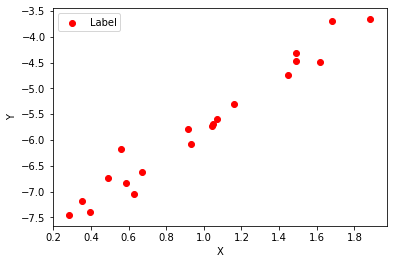

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_regression_data, visualise_regression_data

X, Y = get_regression_data()
print(X.shape, Y.shape)
print(X[0])
visualise_regression_data(X, Y)

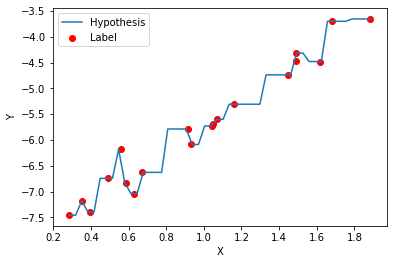

{
    "split_loss": 0.12266555523410844,
    "feature_to_split_on": 0,
    "value_to_split_on": 0.4414857023507669,
    "positive_branch": {
        "split_loss": 0.12485865020159129,
        "feature_to_split_on": 0,
        "value_to_split_on": 0.524884279315537,
        "positive_branch": {
            "split_loss": 0.13593218121094613,
            "feature_to_split_on": 0,
            "value_to_split_on": 0.5726007247492325,
            "positive_branch": {
                "split_loss": 0.11174741295787004,
                "feature_to_split_on": 0,
                "value_to_split_on": 0.7911774227662256,
                "positive_branch": {
                    "split_loss": 0.07053727036133392,
                    "feature_to_split_on": 0,
                    "value_to_split_on": 1.1163505350770109,
                    "positive_branch": {
                        "split_loss": 0.04722455733921024,
                        "feature_to_split_on": 0,
                        "value_to_s

In [2]:
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
import json
import copy

class RegressionTree:
    def __init__(self, max_depth=4):
        self.max_depth = max_depth

    def MSE(self, prediction, label):
        """Compute the MSE between a vector of predictions and the corresponding labels"""
        return np.mean((prediction - label)**2)

    def get_region_loss(self, examples_in_region):
        """Return the MSE loss for a region"""
        x, Y = examples_in_region
        prediction = np.mean(Y)
        return self.MSE(prediction, Y)

    def get_split_loss(self, x, Y, split_pos):
        """Get the weighted loss for a given split"""
        in_first_region = (x[x > split_pos], Y[x > split_pos])
        proportion_in_first_region = len(in_first_region) / len(x)
        not_in_first_region = (x[x <= split_pos], Y[x <= split_pos])
        proportion_not_in_first_region = 1 - proportion_in_first_region
        loss = 0
        loss += proportion_in_first_region * self.get_region_loss(in_first_region)
        loss += proportion_not_in_first_region * self.get_region_loss(not_in_first_region)
        return loss

    def get_split_candidates(self, x):
        """Get the values of a given feature to be tested as a potential place to split"""
        return (x[:-1] + x[1:]) / 2

    def get_best_split(self, X, Y):
        """Return the best feature and the best value on which to split the provided datapoints"""
        best_feature_to_split_on = None
        best_loss = float('inf')
        best_split_pos = None
        n_features = 1
        for feature_idx in range(n_features): # for each feature,
            x = X[:, feature_idx] # get this feature from each example
            split_pos, split_loss = self.get_best_split_on_this_feature(x, Y)
            # print('feature loss:', split_loss)
            if split_loss < best_loss:
                best_split_pos = split_pos
                best_loss = split_loss
                best_feature_to_split_on = feature_idx
        # print('best_split_loss:', best_loss)
        return best_split_pos, best_loss, best_feature_to_split_on

    def get_best_split_on_this_feature(self, x, Y):
        """Get the best value on which to split the data along this axis"""
        split_candidates = self.get_split_candidates(x)
        best_loss = float('inf')
        best_split_pos = None
        for split_pos in split_candidates:
            loss = self.get_split_loss(x, Y, split_pos)
            if loss < best_loss:
                best_loss = loss
                best_split_pos = split_pos
        return best_split_pos, best_loss

    def extend_tree(self, X, Y, depth=0):
        """Recursively make branches of the tree"""
        split_val, split_loss, split_feature = self.get_best_split(X, Y)
        # tree['split']
        if split_val == None: # split val will not exist (None) if there is only one datapoint in the split
            # dsfnucis
            new_branch = {
                'split_loss': 0, # so the split is pure
                'prediction': np.mean(Y)
            }
            return new_branch
        
        positive_idxs = X[:, split_feature] > split_val
        positive_X = X[positive_idxs]
        positive_Y = Y[positive_idxs]
        negative_idxs = np.logical_not(positive_idxs)
        negative_X = X[negative_idxs]
        negative_Y = Y[negative_idxs]
        new_branch = {
            'split_loss': split_loss,
        }

        if depth < self.max_depth: # if not yet at the max depth
            new_branch.update({
                'feature_to_split_on': split_feature,
                'value_to_split_on': split_val,
                'positive_branch': self.extend_tree(positive_X, positive_Y, depth=depth+1),
                'negative_branch': self.extend_tree(negative_X, negative_Y, depth=depth+1)
            })
        else:
            # print(len(Y))
            new_branch.update({'prediction': np.mean(Y)})
        return new_branch

    def fit(self, X, Y):
        """Fit the tree to the data"""
        self.tree = self.extend_tree(X, Y)

    def predict(self, X):
        """Return a prediction for a given input"""
        classifications = np.zeros(len(X))
        for idx, x in enumerate(X):
            tree = self.tree
            classified = False
            while classified == False:
                if 'prediction' in tree.keys(): # if the example can be classified from this branch (we have reached a leaf)
                    classified = True
                    classifications[idx] = tree['prediction']
                else: # if we need to ask further questions about the example to make splits
                    if x[tree['feature_to_split_on']] > tree['value_to_split_on']: # is example1 in the positive branch?
                        tree = tree['positive_branch'] # 
                    else: 
                        tree = tree['negative_branch']
        return classifications

    def __repr__(self):
        """Return the pretty printed string"""
        return json.dumps(self.tree, indent=4)

regressionTree = RegressionTree(max_depth=30)
regressionTree.fit(X, Y)
visualise_regression_data(X, Y, regressionTree.predict)
print(regressionTree)


## Conclusion
At this point, you should have a good understanding of how to

- use decision trees for regression.
- adjust the classification tree to perform regression.